# Prótesis avanzadas
## Modelos de Inteligencia Artificial para control de prótesis con EMG

### Autor: Carlos José Muñoz Cabrera
### Asesor: Daniel Escobar

Este proyecto busca definir un modelo de inteligencia artificial que permita, a partir de la extracción de de caracteristicas de señales EMG, obtener una clasificación de movimientos específicos que puede realizar el usuario y que son los más comunes y usados por la empresa Protesis Avanzadas. Las bases de datos que se usarán para poder realizar este proyecto son las compartidas por NINAPRO, cuya descripción se encuentra en el siguiente documento: ArticuloExplicaciónDB1&DB2.pdf en la carpeta de drive compaertida por la empresa. 

Inicialmente se hace la extracción de datos contenidos en los registros para el primer paciente. Según la documentación y explicación de la base de datos, los registros tienen ciertas características a tener en cuenta y que se van a ir describiendo a lo largo del desarrollo del presente trabajo. 

In [1]:
#Import libraries
import src
from scipy.io import loadmat, whosmat
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd
from src import config

### Importante:

La linea a continuación se usa para descargar los datos de las bases de datos de ninapro. El proceso tarda bastante dado que depende del internet por lo que es mejor explorar la opción de realizarlo manualmente desde la pag de nina-pro

In [2]:
src.prepare_download_data(3)


URLS: ['https://ninapro.hevs.ch/files/db3_Preproc/s1_0.zip', 'https://ninapro.hevs.ch/files/db3_Preproc/s2_0.zip', 'https://ninapro.hevs.ch/files/db3_Preproc/s3_0.zip', 'https://ninapro.hevs.ch/files/db3_Preproc/s4_0.zip', 'https://ninapro.hevs.ch/files/db3_Preproc/s5_0.zip', 'https://ninapro.hevs.ch/files/db3_Preproc/s6_0.zip', 'https://ninapro.hevs.ch/files/db3_Preproc/s7_0.zip', 'https://ninapro.hevs.ch/files/db3_Preproc/s8_0.zip', 'https://ninapro.hevs.ch/files/db3_Preproc/s9_0.zip', 'https://ninapro.hevs.ch/files/db3_Preproc/s10_0.zip', 'https://ninapro.hevs.ch/files/db3_Preproc/s11_0.zip']
Comenzando descarga de https://ninapro.hevs.ch/files/db3_Preproc/s1_0.zip


Se va a verificar los items que contiene el archivo matlab que contiene la información del primer sujeto S1_A1_E1. Estos datos se encuentran registrados en un archivo con extensión .mat. Hacemos uso de la librería scipy ya que es la que se usa parfa el tratamiento de este tipo de datos. 

In [2]:
file = 'signals/DB1/s1\S1_A1_E3.mat'
#Get the description of the information cantained in the file
info = whosmat(file) 
#Get the information contained in the file
mat_file = loadmat(file)
#Print every component in the description of the file
for item in info:
    print(item)  

('emg', (227493, 10), 'double')
('stimulus', (227493, 1), 'double')
('glove', (227493, 22), 'double')
('subject', (1, 1), 'double')
('exercise', (1, 1), 'double')
('repetition', (227493, 1), 'double')
('restimulus', (227493, 1), 'double')
('rerepetition', (227493, 1), 'double')


<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\CarlosMunoz\AppData\Local\Temp\ipykernel_27064\2811683986.py:1: SyntaxWarning: invalid escape sequence '\S'
  file = 'signals/DB1/s1\S1_A1_E3.mat'


In [3]:
#Access each of the matrices by its name
emg = mat_file['emg']
stimulus = mat_file['stimulus']
glove = mat_file['glove']
subject = mat_file['subject']
exercise = mat_file['exercise']
repetition = mat_file['repetition']
restimulus = mat_file['restimulus']
rerepetition = mat_file['rerepetition']


A continuación se procede a explorar cada una de las matrices contenidas en el archivo, dando una breve descripción de la información que contienen. Con el objetivo de conocer con más detalle que es lo que cada archivo contiene.

No se tiene una base de tiempo. 

### 1. EMG
Los valores de emg incluyen la señal sEMG obtenida por los electrodos. La columna 1 a la 8 incluyen la señal obtenida de los electrodos igualmente espaciados en el antebrazo.
La columna 9 y 10 hace referencia a los electrodos ubicados en la principal zona de activación del músculo flexor superficial de los dedos y el musculo extensor superficial de los dedos. Si existe un electrodo 11 y 12, pertenece a la señal de activación del músculo biceps braquial y triceps braquial.


In [4]:
#Print emg Matrix
print("Valores de 'emg':")
print(f'Tipo de dato: {type(emg)}')
print(emg)

Valores de 'emg':
Tipo de dato: <class 'numpy.ndarray'>
[[0.0024 0.0024 0.0024 ... 0.0732 0.0024 0.0903]
 [0.0024 0.0024 0.0024 ... 0.0757 0.0024 0.0928]
 [0.0024 0.0024 0.0024 ... 0.0879 0.0024 0.0903]
 ...
 [0.0024 0.0024 0.0024 ... 0.0513 0.127  0.0024]
 [0.0024 0.0024 0.0024 ... 0.0488 0.1294 0.0024]
 [0.0024 0.0024 0.0024 ... 0.0439 0.1294 0.0024]]


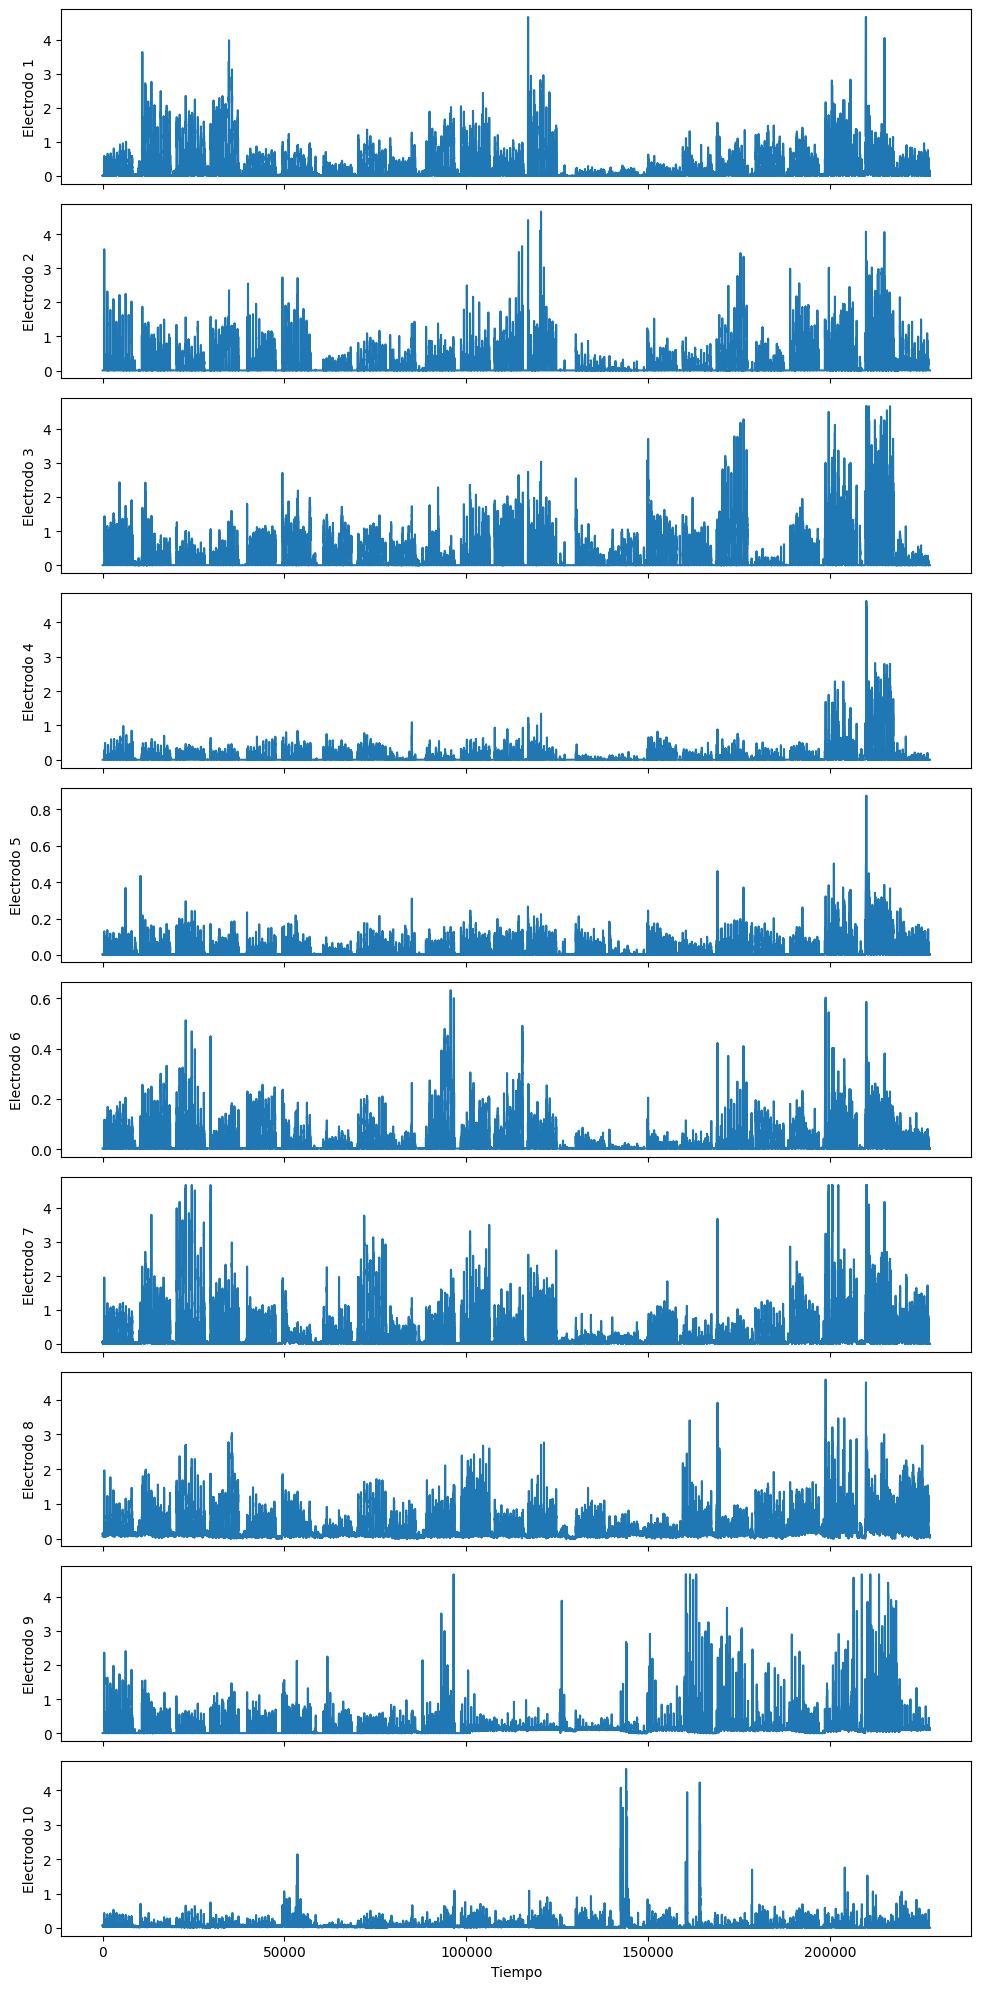

In [5]:
#Plot the emg signal
fig, axs = plt.subplots(10, 1, figsize=(10, 20), sharex=True)

for i, ax in enumerate(axs):
    ax.plot(emg[:, i])
    ax.set_ylabel(f'Electrodo {i+1}')
    ax.grid=True

axs[-1].set_xlabel('Tiempo')

plt.tight_layout()

# plt.show()

### 2. Stimulus
Representa la etiqueta original del movimiento que está realizando el sujeto. Estos movimientos deben clasificarse en los que se va a usar en protesis avanzadas y los que no, por esta razón es necesario hacer la clasificación de dichas etiquetas. 

In [6]:
print("Valores de 'stimulus':")
unique_values = np.unique(stimulus)

# Print unique values
print(unique_values)


Valores de 'stimulus':
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


Text(0.5, 1.0, 'Valor del estímulo')

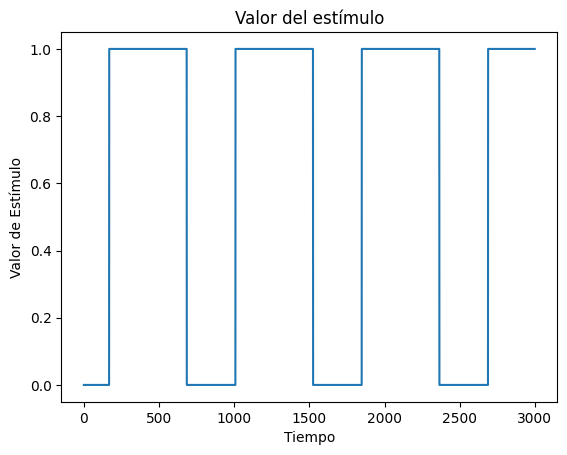

In [7]:
#Plot the stimulus
fig, ax = plt.subplots()

ax.plot(stimulus[1000:4000])

ax.set_xlabel('Tiempo')
ax.set_ylabel('Valor de Estímulo')
ax.set_title('Valor del estímulo')

# plt.show()

### 3. Glove
Los valores de glove hacen referencia a la señal no calibrada de los 22 sensores de cyberglove que son úbicados en las manos. 

In [8]:
print("Valores de 'glove':")
# print(glove)

Valores de 'glove':


### 4. Subject

El subject se refiere al sujeto en cuestión que está realizando la prueba y de quien pertencen los registros

In [9]:
print("Valor de 'subject':")
print(subject)

Valor de 'subject':
[[1]]


### 4. Excercise

Se refiere al numero del ejercicio que fue realizado por el sujeto. En esta base de datos se cuenta con 3 tipos de ejercicios que tienen diferentes movimientos según sea el caso

In [10]:
print("Valor de 'exercise':")
print(exercise)

Valor de 'exercise':
[[3]]


### 5. Repetition:
Se refiere al indice de repetición del estímulo

In [11]:
print("Valores de 'repetition':")
unique_values = np.unique(repetition)

# Print unique values
print(unique_values)

Valores de 'repetition':
[ 0  1  2  3  4  5  6  7  8  9 10]


Text(0.5, 1.0, 'Valor del Repetition')

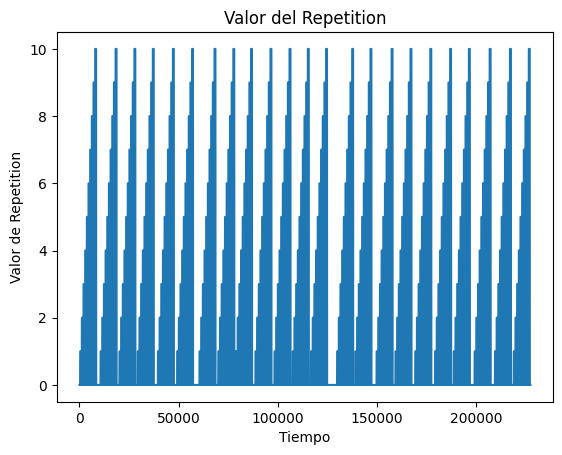

In [12]:
#Plot the repetition
fig, ax = plt.subplots()

ax.plot(repetition)

ax.set_xlabel('Tiempo')
ax.set_ylabel('Valor de Repetition')
ax.set_title('Valor del Repetition')

# plt.show()

### 6. Restimulus

Se refiere a la etiqueta refinada a-posteriori del movimiento realizado por el sujeto

In [13]:
print("\nValores de 'restimulus':")
unique_values = np.unique(restimulus)

# Print unique values
print(unique_values)


Valores de 'restimulus':
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


Text(0.5, 1.0, 'Valor del restimulus')

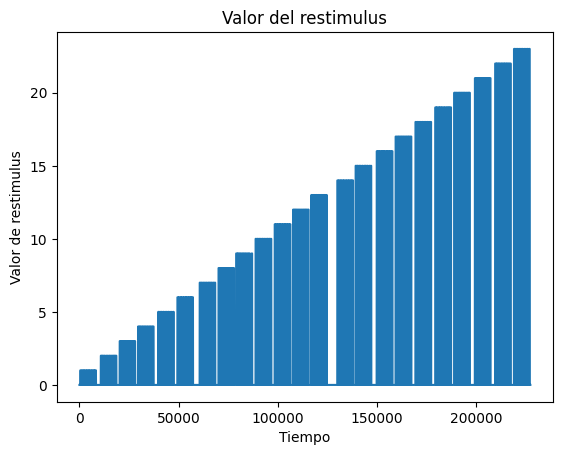

In [14]:
#Plot the restimulus
fig, ax = plt.subplots()

ax.plot(restimulus)

ax.set_xlabel('Tiempo')
ax.set_ylabel('Valor de restimulus')
ax.set_title('Valor del restimulus')

# plt.show()

### 7. Rerepetition

Se refiere al indice de repetición del estimulo

In [15]:
print("Valores de 'rerepetition':")
unique_values = np.unique(rerepetition)

# Print unique values
print(unique_values)

Valores de 'rerepetition':
[ 0  1  2  3  4  5  6  7  8  9 10]


Text(0.5, 1.0, 'Valor del Rerepetition')

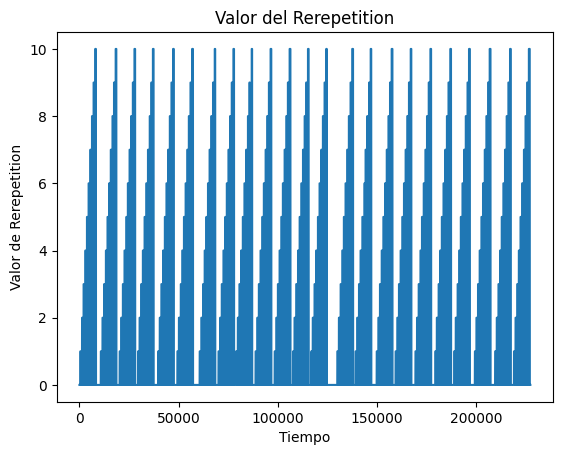

In [16]:
#Plot the Rerepetition
fig, ax = plt.subplots()

ax.plot(rerepetition)

ax.set_xlabel('Tiempo')
ax.set_ylabel('Valor de Rerepetition')
ax.set_title('Valor del Rerepetition')

# plt.show()

Como se puede ver en las gráficas. Para este primer ejercicio, por cada movimiento se realizaron 10 repeticiones y volviendo al estado de reposo que se indica en el articulo de explicación de la base de datos. Dado que no se van a usar todos los movimientos, solo los que se asocian con los que usa la empresa, es necesario hacer una división de las señales de emg y glove para poder definir cuales sonlas señales correspondientes al movimiento y su repetición. 

Dado que tenemos una señal de restimulus, vamos a usar esta como punto de partida para hacer dicha división, tomando la sincronía que debe tener la señal. Existen dos opciones que se deben discutir, la primera es que se pueden segmentar las señales de inicio de estímulo a inicio de estímulo o de fin de estímulo a fin de estímulo.

En este mommento se va a realizar la segmentación solo cuando el estímulo se encuentra activo. Sin embargo, es algo que se debe discutir con el asesor.

Entonces, para el proceso. Primero encontramos los indices donde se realiza el estímulo. La idea es encontras los indices donde el estímulo es diferente de 0.

In [17]:
start_index_stimulus, end_index_stimulus = src.get_stimulus_index(restimulus)
# print('start index stimulus: ', start_index_stimulus)
# print('start index stimulus len: ', len(start_index_stimulus))
# print('end index stimulus: ', end_index_stimulus)
# print('end index stimulus len : ', len(end_index_stimulus))


Los indices de inicio indican el momento antes de comenzar el estímulo, por lo que el inicio comienza en n+1

In [18]:
print(f'Start index: {restimulus[391][0]}')
print(f'Start real: {restimulus[717][0]}')
print(f'End real index: {restimulus[1259][0]}')

Start index: 1
Start real: 1
End real index: 0


Ahora se procede a segmentar la señal de los sensores EMG para poder así obtener la señal con su respectiva etiqueta. Según  lo conversado en las reuniones de segumiento, los movimientos que se van a tener en cuenta en el primer ejercicio son los 9,10,11,12. De esta manera se procede a segmentar estos indices de las señales de emg.

In [19]:
movements = np.array([5,6,9,10])

filtered_start_index_stimulus = src.get_start_end_index(start_index_stimulus, end_index_stimulus, movements, 10)

In [20]:
print(filtered_start_index_stimulus['5'])

{'start': array([39668, 40474, 41279, 42145, 43035, 43849, 44665, 45544, 46371,
       47180], dtype=int64), 'end': array([37397, 40067, 40847, 41691, 42537, 43365, 44223, 45074, 45870,
       46729, 47584], dtype=int64)}


In [21]:
for i in filtered_start_index_stimulus:
    print(i)

5
6
9
10


Para este primer ejemplo, la señal está iniciando con el primer end index +1 ya que es aquí donde comienza el reposo y despúes se obtiene la señal dónde comienza el estimulo

In [22]:
print(f'Este es el inicio del reposo: {restimulus[37397+1][0]}')
print(f'Aquí es donde comienza el estímulo: {restimulus[39668+1][0]}')
print(f'Aquí es donde termina el estímulo: {restimulus[47584][0]}')

Este es el inicio del reposo: 0
Aquí es donde comienza el estímulo: 5
Aquí es donde termina el estímulo: 5


Como se observa anteriormente, hemos guardado en el diccionario 10 indices que indican el inicio del estímulo en cuestion y 11 que indican el fin del estímulo o el comienzo del reposo. Dado que tenemos la señal de emg sincronizada con la señal de restimulus, entonces usaremos el mismo indice para hacer la segmentación de dicha señal logrando que una señal empiece en el reposo y termine cuando se termina el estímulo. Sin embargo, es preciso determinar si es mejor segmentar la señal cuando se tiene solo estímulo o cuando se tiene solo reposo.

In [23]:
segmented_signals = src.get_signal_by_movement_complete(emg[:,0], filtered_start_index_stimulus['5'])

In [24]:
segmented_restimulus = src.get_signal_by_movement_complete(restimulus, filtered_start_index_stimulus['5'])

In [25]:
print(segmented_signals)

[0.1025 0.0757 0.0635 ... 0.0024 0.0024 0.0024]


Procedemos a Graficarlas para poder verificar visualmente

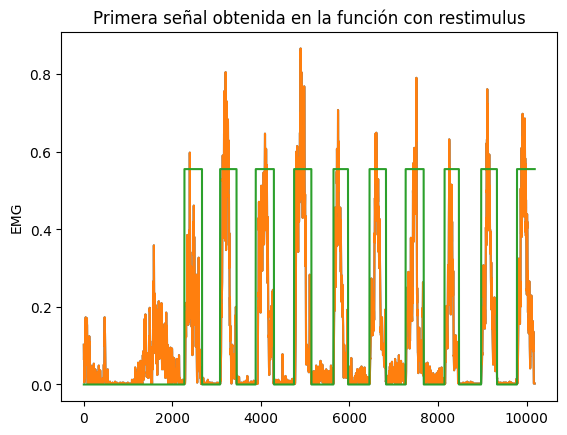

In [26]:
fig, ax = plt.subplots()

ax.plot(segmented_signals)
ax.plot(emg[37397+1:47584, 0])
ax.plot(segmented_restimulus*1/9)

ax.set_ylabel('EMG')
ax.set_title('Primera señal obtenida en la función con restimulus')

plt.show()

Dado que ya tenemos las señales segmentadas, se procede a obtener la envolvente, primero sin aplicar filtros y después aplicando un filtro

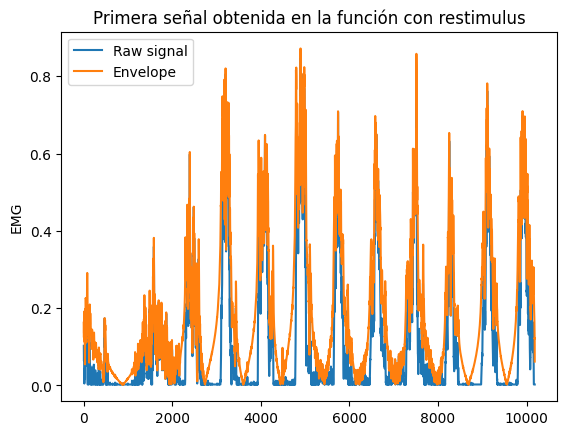

In [27]:
envelope = src.get_envelope(segmented_signals)

fig, ax = plt.subplots()

ax.plot(segmented_signals)
ax.plot(envelope)

ax.set_ylabel('EMG')
ax.set_title('Primera señal obtenida en la función con restimulus')
ax.legend(['Raw signal', 'Envelope'])

# plt.show()


In [28]:
filtered_signal = src.get_filtered_signal(segmented_signals, 10, 2000)

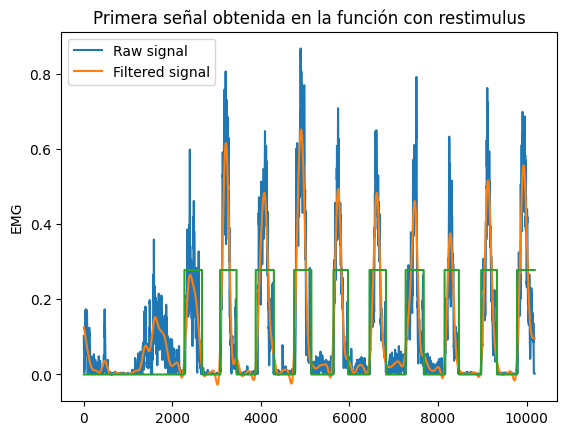

In [29]:
fig, ax = plt.subplots()

ax.plot(segmented_signals)
ax.plot(filtered_signal)
ax.plot(restimulus[37397+1:47584]/(2*9))

ax.set_ylabel('EMG')
ax.set_title('Primera señal obtenida en la función con restimulus')
ax.legend(['Raw signal', 'Filtered signal'])

plt.show()

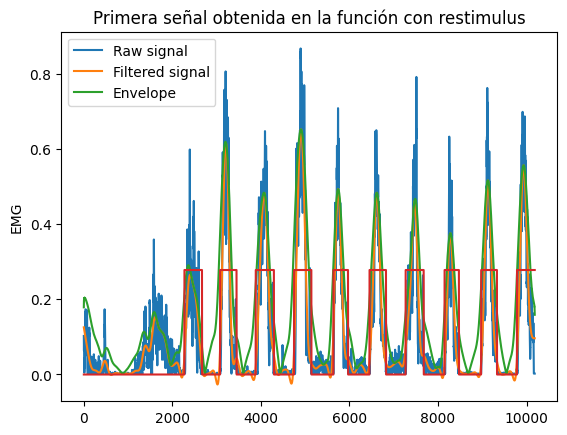

In [30]:
envelope = src.get_envelope(filtered_signal)

fig, ax = plt.subplots()

ax.plot(segmented_signals)
ax.plot(filtered_signal)
ax.plot(envelope)
ax.plot(restimulus[37397+1:47584]/(2*9))

ax.set_ylabel('EMG')
ax.set_title('Primera señal obtenida en la función con restimulus')
ax.legend(['Raw signal', 'Filtered signal', 'Envelope'])

plt.show()

In [31]:
main_folder_path = f'signals/DB1/'
signal_paths = []
for folder in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder)  
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path) and 'E3' in file and file.endswith('.mat'):
                signal_paths.append(file_path)

print(signal_paths)

['signals/DB1/s1\\S1_A1_E3.mat', 'signals/DB1/s10\\S10_A1_E3.mat', 'signals/DB1/s11\\S11_A1_E3.mat', 'signals/DB1/s12\\S12_A1_E3.mat', 'signals/DB1/s13\\S13_A1_E3.mat', 'signals/DB1/s14\\S14_A1_E3.mat', 'signals/DB1/s15\\S15_A1_E3.mat', 'signals/DB1/s16\\S16_A1_E3.mat', 'signals/DB1/s17\\S17_A1_E3.mat', 'signals/DB1/s18\\S18_A1_E3.mat', 'signals/DB1/s19\\S19_A1_E3.mat', 'signals/DB1/s2\\S2_A1_E3.mat', 'signals/DB1/s20\\S20_A1_E3.mat', 'signals/DB1/s21\\S21_A1_E3.mat', 'signals/DB1/s22\\S22_A1_E3.mat', 'signals/DB1/s23\\S23_A1_E3.mat', 'signals/DB1/s24\\S24_A1_E3.mat', 'signals/DB1/s25\\S25_A1_E3.mat', 'signals/DB1/s26\\S26_A1_E3.mat', 'signals/DB1/s27\\S27_A1_E3.mat', 'signals/DB1/s3\\S3_A1_E3.mat', 'signals/DB1/s4\\S4_A1_E3.mat', 'signals/DB1/s5\\S5_A1_E3.mat', 'signals/DB1/s6\\S6_A1_E3.mat', 'signals/DB1/s7\\S7_A1_E3.mat', 'signals/DB1/s8\\S8_A1_E3.mat', 'signals/DB1/s9\\S9_A1_E3.mat']


Creamos una rutina para iterar sobre cada BD con el ejercicio 3 que son los que usaremos para la clasificación. Aunque, se va a explorar sobre los demás ejercicios, buscando obtener los movimientos que más se diferencian.

In [32]:
#All column titles are created with features to classify signals.
column_titles = ['label']
features = config.FEATURES
for i in range(8):
    for feature in features.keys():
        column_titles.append(feature+str(i+1))
signals_features = pd.DataFrame(columns=column_titles)
print(signals_features)

Empty DataFrame
Columns: [label, RMS_E1, MAV_E1, VARIANCE_E1, SAMPLE_VARIANCE_E1, RMS_E2, MAV_E2, VARIANCE_E2, SAMPLE_VARIANCE_E2, RMS_E3, MAV_E3, VARIANCE_E3, SAMPLE_VARIANCE_E3, RMS_E4, MAV_E4, VARIANCE_E4, SAMPLE_VARIANCE_E4, RMS_E5, MAV_E5, VARIANCE_E5, SAMPLE_VARIANCE_E5, RMS_E6, MAV_E6, VARIANCE_E6, SAMPLE_VARIANCE_E6, RMS_E7, MAV_E7, VARIANCE_E7, SAMPLE_VARIANCE_E7, RMS_E8, MAV_E8, VARIANCE_E8, SAMPLE_VARIANCE_E8]
Index: []

[0 rows x 33 columns]


In [33]:
movements_label = config.MOVEMENTS_LABEL
movements_as_integers = sorted(list(map(int, movements_label.keys())))

In [34]:
#Routine to create data frame with characteristics and labels.
databases = config.DATABASES
fc= config.FC #Cutoff frequency in Hz
windowing = config.WINDOWING #s time of the window // Ej: 0.2s = 200 ms
overlapping = config.OVERLAPPING #% overlapping percentage
repetitions = config.REPETITIONS #Number of times a movement is repeated
electrodes = config.ELECTRODES #Number of electrodes used in the experiment
threshold = config.THRESHOLD # Characterization percentage
for database, fm in databases.items(): #Iterates over databases
    window_length = int(windowing * fm)
    subjects = src.get_file_path_database(database)
    for individual in subjects: #Iterates over individuals in the experiments
        mat_file = loadmat(individual)
        emg = mat_file['emg']
        re_stimulus = mat_file['restimulus']
        re_repetition = mat_file['rerepetition']
        start_index_re_stimulus, end_index_re_stimulus = src.get_stimulus_index(re_stimulus) # Get the start and end index of the entire set of repetitions for an exercise.
        filtered_start_index_re_stimulus = src.get_start_end_index(
            start_index_re_stimulus, 
            end_index_re_stimulus, 
            movements_as_integers, 
            repetitions
        ) #Get the segments of the entire set of repetitions for an exercise. 
        for movement in movements_as_integers: #Iterates over the movements implied in the classification 
            if movement == 0:
                continue
            segmented_re_stimulus = src.get_signal_by_movement_complete(re_stimulus, filtered_start_index_re_stimulus[str(movement)]) #Gets the signal of the movement
            windows_re_stimulus = src.create_windows_with_overlap(segmented_re_stimulus, window_length, overlapping)
            labels = []
            for window in windows_re_stimulus:
                label = src.get_label(window, threshold, movements_label)
                labels.append(label)
            emg_signals = []
            for electrode in range(electrodes):
                segmented_emg_signal = src.get_signal_by_movement_complete(emg[:, electrode], filtered_start_index_re_stimulus[str(movement)])
                filtered_segmented_emg_signal = src.get_envelope_filtered(segmented_emg_signal, fc, fm)
                windows_emg_electrode = src.create_windows_with_overlap(filtered_segmented_emg_signal, window_length, overlapping)
                emg_signals.append(windows_emg_electrode)
            windows_quantity  = len(emg_signals[0])
            if (windows_quantity != len(labels)):
                print('Different longitude in labels with electrodes', movement, individual, database) #This is used to check the windows between labels and windows in electrodes
                raise ValueError('No es compatible')
            for index_label,label in enumerate(labels):
                if not label:
                    print(label)
                data_label = {
                    'label': label,
                }
                for index_electrode, element in enumerate(emg_signals):
                    if len(element) != windows_quantity:
                        print('Different longitude in electrodes', index_electrode, movement, individual, database) #This is used to find any signal with different number of window
                        raise ValueError('No es compatible')
                    for feature, function in features.items():
                        feature_calculus = function(element[index_label])
                        data_label[feature+str(index_electrode+1)] = np.array([feature_calculus])
                new_data_label = pd.DataFrame(data_label)
                signals_features = pd.concat([signals_features, new_data_label], ignore_index=True)


C:\Users\CarlosMunoz\AppData\Local\Temp\ipykernel_27064\1752380685.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  signals_features = pd.concat([signals_features, new_data_label], ignore_index=True)


In [35]:
signals_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49670 entries, 0 to 49669
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               49670 non-null  object 
 1   RMS_E1              49670 non-null  float64
 2   MAV_E1              49670 non-null  float64
 3   VARIANCE_E1         49670 non-null  float64
 4   SAMPLE_VARIANCE_E1  49670 non-null  float64
 5   RMS_E2              49670 non-null  float64
 6   MAV_E2              49670 non-null  float64
 7   VARIANCE_E2         49670 non-null  float64
 8   SAMPLE_VARIANCE_E2  49670 non-null  float64
 9   RMS_E3              49670 non-null  float64
 10  MAV_E3              49670 non-null  float64
 11  VARIANCE_E3         49670 non-null  float64
 12  SAMPLE_VARIANCE_E3  49670 non-null  float64
 13  RMS_E4              49670 non-null  float64
 14  MAV_E4              49670 non-null  float64
 15  VARIANCE_E4         49670 non-null  float64
 16  SAMP

In [36]:
signals_features.describe()

,RMS_E1,MAV_E1,VARIANCE_E1,SAMPLE_VARIANCE_E1,RMS_E2,MAV_E2,VARIANCE_E2,SAMPLE_VARIANCE_E2,RMS_E3,MAV_E3,...,VARIANCE_E6,SAMPLE_VARIANCE_E6,RMS_E7,MAV_E7,VARIANCE_E7,SAMPLE_VARIANCE_E7,RMS_E8,MAV_E8,VARIANCE_E8,SAMPLE_VARIANCE_E8
count,49670.000000,49670.000000,4.967000e+04,4.967000e+04,49670.000000,49670.000000,4.967000e+04,4.967000e+04,49670.000000,49670.000000,...,4.967000e+04,4.967000e+04,49670.000000,49670.000000,4.967000e+04,4.967000e+04,49670.000000,49670.000000,4.967000e+04,4.967000e+04
mean,0.335818,0.333598,2.495057e-03,2.537346e-03,0.166598,0.165158,9.217022e-04,9.373243e-04,0.166647,0.165170,...,6.480557e-04,6.590397e-04,0.380425,0.377997,2.840437e-03,2.888580e-03,0.419207,0.416734,2.701637e-03,2.747427e-03
std,0.438499,0.437346,7.351340e-03,7.475939e-03,0.238285,0.237352,3.961222e-03,4.028361e-03,0.305225,0.303800,...,4.529084e-03,4.605848e-03,0.439812,0.438674,9.354022e-03,9.512565e-03,0.393396,0.392588,7.886083e-03,8.019746e-03
min,0.001816,0.001750,1.974863e-12,2.008335e-12,0.001591,0.001570,1.908052e-22,1.940392e-22,0.001785,0.001652,...,3.693777e-19,3.756383e-19,0.002487,0.002407,7.601341e-10,7.730177e-10,0.003746,0.003595,8.400423e-10,8.542803e-10
25%,0.028441,0.027453,5.715754e-06,5.812631e-06,0.025557,0.024747,8.016434e-06,8.152306e-06,0.019234,0.018614,...,1.206059e-06,1.226501e-06,0.106760,0.105273,5.331395e-05,5.421758e-05,0.152462,0.150693,7.332135e-05,7.456408e-05
50%,0.167465,0.165544,1.794479e-04,1.824894e-04,0.078955,0.077941,6.821963e-05,6.937589e-05,0.063291,0.062148,...,1.529652e-05,1.555579e-05,0.225039,0.223219,3.293409e-04,3.349230e-04,0.303453,0.300801,4.522142e-04,4.598788e-04
75%,0.470194,0.466460,1.476775e-03,1.501805e-03,0.208778,0.206714,4.209531e-04,4.280879e-04,0.185731,0.183454,...,1.066228e-04,1.084300e-04,0.479563,0.476571,1.698976e-03,1.727772e-03,0.563854,0.560879,2.203640e-03,2.240990e-03
max,3.838705,3.838496,3.000401e-01,3.051256e-01,3.188070,3.187240,3.394510e-01,3.452044e-01,4.930990,4.930632,...,1.785957e-01,1.816227e-01,4.106075,4.105875,3.258267e-01,3.313492e-01,4.507559,4.507473,4.928349e-01,5.011880e-01


In [37]:
signals_features['label'].value_counts()

label
Base              28351
Lateral            3729
Ring               3451
Medium Wrap        3373
Power Sphere       3257
Writing Tripod     3205
Tripod             3188
None               1116
Name: count, dtype: int64

In [39]:
#Save dataframe 
signals_features.to_pickle('preprocessed_data/signals_50OL_03Windowing.pkl')

# Análisis y limpieza de datos

Una vez se logra obtener el dataset completo se procede a hacer un análisis y limpieza de datos para poder ingresarlos a los diferentes algoritmos de clasificación


In [42]:
import pandas as pd
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [44]:
signals_features_df = pd.read_pickle('preprocessed_data/signals_50OL_03Windowing.pkl') #upload data_frame
print('Head of dataset:')
print(signals_features_df.head())

Head of dataset:
  label    RMS_E1    MAV_E1  VARIANCE_E1  SAMPLE_VARIANCE_E1    RMS_E2  \
0  Base  0.200014  0.199970     0.000018            0.000018  0.202461   
1  Base  0.193816  0.193720     0.000037            0.000038  0.154873   
2  Base  0.181736  0.181561     0.000063            0.000064  0.134383   
3  Base  0.166725  0.166455     0.000090            0.000092  0.120167   
4  Base  0.149564  0.149202     0.000108            0.000110  0.109139   

     MAV_E2  VARIANCE_E2  SAMPLE_VARIANCE_E2    RMS_E3  ...  VARIANCE_E6  \
0  0.197485     0.001990            0.002024  0.459723  ...     0.000026   
1  0.154214     0.000204            0.000207  0.342896  ...     0.000007   
2  0.134057     0.000087            0.000089  0.294403  ...     0.000004   
3  0.119960     0.000050            0.000050  0.261695  ...     0.000003   
4  0.108991     0.000032            0.000033  0.236985  ...     0.000002   

   SAMPLE_VARIANCE_E6    RMS_E7    MAV_E7  VARIANCE_E7  SAMPLE_VARIANCE_E7  \
0  

In [45]:
print('Numeric data information:')
print(signals_features_df.info())

Numeric data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49670 entries, 0 to 49669
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               49670 non-null  object 
 1   RMS_E1              49670 non-null  float64
 2   MAV_E1              49670 non-null  float64
 3   VARIANCE_E1         49670 non-null  float64
 4   SAMPLE_VARIANCE_E1  49670 non-null  float64
 5   RMS_E2              49670 non-null  float64
 6   MAV_E2              49670 non-null  float64
 7   VARIANCE_E2         49670 non-null  float64
 8   SAMPLE_VARIANCE_E2  49670 non-null  float64
 9   RMS_E3              49670 non-null  float64
 10  MAV_E3              49670 non-null  float64
 11  VARIANCE_E3         49670 non-null  float64
 12  SAMPLE_VARIANCE_E3  49670 non-null  float64
 13  RMS_E4              49670 non-null  float64
 14  MAV_E4              49670 non-null  float64
 15  VARIANCE_E4         49670 n

In [46]:
print('Numeric data description:')
print(signals_features_df.describe())

Numeric data description:
             RMS_E1        MAV_E1   VARIANCE_E1  SAMPLE_VARIANCE_E1  \
count  49670.000000  49670.000000  4.967000e+04        4.967000e+04   
mean       0.335818      0.333598  2.495057e-03        2.537346e-03   
std        0.438499      0.437346  7.351340e-03        7.475939e-03   
min        0.001816      0.001750  1.974863e-12        2.008335e-12   
25%        0.028441      0.027453  5.715754e-06        5.812631e-06   
50%        0.167465      0.165544  1.794479e-04        1.824894e-04   
75%        0.470194      0.466460  1.476775e-03        1.501805e-03   
max        3.838705      3.838496  3.000401e-01        3.051256e-01   

             RMS_E2        MAV_E2   VARIANCE_E2  SAMPLE_VARIANCE_E2  \
count  49670.000000  49670.000000  4.967000e+04        4.967000e+04   
mean       0.166598      0.165158  9.217022e-04        9.373243e-04   
std        0.238285      0.237352  3.961222e-03        4.028361e-03   
min        0.001591      0.001570  1.908052e-22   

In [47]:
signals_features_df['label'].value_counts()

label
Base              28351
Lateral            3729
Ring               3451
Medium Wrap        3373
Power Sphere       3257
Writing Tripod     3205
Tripod             3188
None               1116
Name: count, dtype: int64

In [48]:
index_to_delete = signals_features_df[signals_features_df['label'] == 'None'].index

signals_features_df.drop(index_to_delete, inplace=True)

Es importante recalcar que las etiquetas clasificadas como Base superan en gran medida a las demás etiquetas a clasificar por lo que vamos a aplicar submuetreo sobre los datos para poder igualar los datos de la base y que sea de manera aleatoria. De esta manera buscamos balancear los datos y que así no exista un  sesgo en la clasificación.


In [49]:
X = signals_features_df.drop('label', axis=1)
y = signals_features_df['label']

rus = RandomUnderSampler(random_state=40)
X_res, y_res = rus.fit_resample(X, y)

print(f"Distribución de clases antes de Under-sampling: {Counter(y)}")
print(f"Distribución de clases después de Under-sampling: {Counter(y_res)}")

Distribución de clases antes de Under-sampling: Counter({'Base': 28351, 'Lateral': 3729, 'Ring': 3451, 'Medium Wrap': 3373, 'Power Sphere': 3257, 'Writing Tripod': 3205, 'Tripod': 3188})
Distribución de clases después de Under-sampling: Counter({'Base': 3188, 'Lateral': 3188, 'Medium Wrap': 3188, 'Power Sphere': 3188, 'Ring': 3188, 'Tripod': 3188, 'Writing Tripod': 3188})


In [50]:
df_balanced = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.DataFrame(y_res, columns=['label'])], axis=1)

In [51]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22316 entries, 41253 to 41373
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RMS_E1              22316 non-null  float64
 1   MAV_E1              22316 non-null  float64
 2   VARIANCE_E1         22316 non-null  float64
 3   SAMPLE_VARIANCE_E1  22316 non-null  float64
 4   RMS_E2              22316 non-null  float64
 5   MAV_E2              22316 non-null  float64
 6   VARIANCE_E2         22316 non-null  float64
 7   SAMPLE_VARIANCE_E2  22316 non-null  float64
 8   RMS_E3              22316 non-null  float64
 9   MAV_E3              22316 non-null  float64
 10  VARIANCE_E3         22316 non-null  float64
 11  SAMPLE_VARIANCE_E3  22316 non-null  float64
 12  RMS_E4              22316 non-null  float64
 13  MAV_E4              22316 non-null  float64
 14  VARIANCE_E4         22316 non-null  float64
 15  SAMPLE_VARIANCE_E4  22316 non-null  float64
 16  RMS_E

In [52]:
df_balanced.describe()

,RMS_E1,MAV_E1,VARIANCE_E1,SAMPLE_VARIANCE_E1,RMS_E2,MAV_E2,VARIANCE_E2,SAMPLE_VARIANCE_E2,RMS_E3,MAV_E3,...,VARIANCE_E6,SAMPLE_VARIANCE_E6,RMS_E7,MAV_E7,VARIANCE_E7,SAMPLE_VARIANCE_E7,RMS_E8,MAV_E8,VARIANCE_E8,SAMPLE_VARIANCE_E8
count,22316.000000,22316.000000,2.231600e+04,2.231600e+04,22316.000000,22316.000000,2.231600e+04,2.231600e+04,22316.000000,22316.000000,...,2.231600e+04,2.231600e+04,22316.000000,22316.000000,2.231600e+04,2.231600e+04,22316.000000,22316.000000,2.231600e+04,2.231600e+04
mean,0.495500,0.493306,3.357337e-03,3.414241e-03,0.256342,0.254779,1.360586e-03,1.383647e-03,0.261351,0.259820,...,1.157433e-03,1.177051e-03,0.545230,0.542915,3.595172e-03,3.656107e-03,0.587699,0.585392,3.273065e-03,3.328541e-03
std,0.551010,0.549931,8.160523e-03,8.298837e-03,0.300346,0.299410,4.312117e-03,4.385204e-03,0.397247,0.395765,...,6.370435e-03,6.478408e-03,0.535474,0.534468,1.049921e-02,1.067716e-02,0.462708,0.462095,8.383337e-03,8.525427e-03
min,0.001973,0.001883,1.974863e-12,2.008335e-12,0.001591,0.001570,9.098609e-21,9.252823e-21,0.001785,0.001725,...,3.693777e-19,3.756383e-19,0.002487,0.002407,2.651848e-09,2.696795e-09,0.006365,0.005825,1.908089e-08,1.940430e-08
25%,0.043748,0.042783,9.703481e-06,9.867946e-06,0.056956,0.055891,1.812812e-05,1.843537e-05,0.038507,0.037826,...,2.512039e-06,2.554616e-06,0.171688,0.169912,9.163163e-05,9.318471e-05,0.265529,0.263904,1.431023e-04,1.455278e-04
50%,0.300764,0.298434,3.045573e-04,3.097193e-04,0.156055,0.154728,1.329732e-04,1.352270e-04,0.133205,0.131900,...,2.761166e-05,2.807965e-05,0.363610,0.361754,5.128336e-04,5.215257e-04,0.486856,0.484552,7.251778e-04,7.374690e-04
75%,0.778635,0.776464,2.604211e-03,2.648350e-03,0.344911,0.342492,7.811290e-04,7.943685e-04,0.326591,0.324642,...,2.412834e-04,2.453730e-04,0.745165,0.741932,2.536658e-03,2.579653e-03,0.775032,0.772446,2.922880e-03,2.972421e-03
max,3.838705,3.838496,1.427174e-01,1.451363e-01,3.188070,3.187240,1.136926e-01,1.156196e-01,4.930990,4.930632,...,1.785957e-01,1.816227e-01,4.106075,4.105875,2.620883e-01,2.665305e-01,4.507559,4.507473,3.578309e-01,3.638958e-01


Vamos a obtener un dataframe sin la clase Base para ver como se comporta la clasificación, aunque esto no es lo recomendado simplemente se hace para poder realizar comparaciones

In [53]:
df_filtered = signals_features_df[signals_features_df['label'] != 'Base'].copy()

In [54]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20203 entries, 75 to 49669
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               20203 non-null  object 
 1   RMS_E1              20203 non-null  float64
 2   MAV_E1              20203 non-null  float64
 3   VARIANCE_E1         20203 non-null  float64
 4   SAMPLE_VARIANCE_E1  20203 non-null  float64
 5   RMS_E2              20203 non-null  float64
 6   MAV_E2              20203 non-null  float64
 7   VARIANCE_E2         20203 non-null  float64
 8   SAMPLE_VARIANCE_E2  20203 non-null  float64
 9   RMS_E3              20203 non-null  float64
 10  MAV_E3              20203 non-null  float64
 11  VARIANCE_E3         20203 non-null  float64
 12  SAMPLE_VARIANCE_E3  20203 non-null  float64
 13  RMS_E4              20203 non-null  float64
 14  MAV_E4              20203 non-null  float64
 15  VARIANCE_E4         20203 non-null  float64
 16  SAMPLE_V

In [55]:
df_filtered.describe()

,RMS_E1,MAV_E1,VARIANCE_E1,SAMPLE_VARIANCE_E1,RMS_E2,MAV_E2,VARIANCE_E2,SAMPLE_VARIANCE_E2,RMS_E3,MAV_E3,...,VARIANCE_E6,SAMPLE_VARIANCE_E6,RMS_E7,MAV_E7,VARIANCE_E7,SAMPLE_VARIANCE_E7,RMS_E8,MAV_E8,VARIANCE_E8,SAMPLE_VARIANCE_E8
count,20203.000000,20203.000000,2.020300e+04,2.020300e+04,20203.000000,20203.000000,2.020300e+04,2.020300e+04,20203.000000,20203.000000,...,2.020300e+04,2.020300e+04,20203.000000,20203.000000,2.020300e+04,2.020300e+04,20203.000000,20203.000000,2.020300e+04,2.020300e+04
mean,0.542285,0.540077,3.627198e-03,3.688676e-03,0.280532,0.278939,1.471238e-03,1.496174e-03,0.291348,0.289785,...,1.291592e-03,1.313483e-03,0.594465,0.592192,3.814374e-03,3.879024e-03,0.642758,0.640498,3.461402e-03,3.520070e-03
std,0.569396,0.568309,8.420244e-03,8.562960e-03,0.309242,0.308302,4.415577e-03,4.490417e-03,0.421147,0.419611,...,6.753151e-03,6.867611e-03,0.551149,0.550134,1.073421e-02,1.091615e-02,0.471449,0.470853,8.198412e-03,8.337368e-03
min,0.001973,0.001883,1.974863e-12,2.008335e-12,0.001591,0.001570,1.197291e-20,1.217584e-20,0.001785,0.001725,...,3.693777e-19,3.756383e-19,0.006939,0.005925,2.498679e-08,2.541030e-08,0.008556,0.008046,1.908089e-08,1.940430e-08
25%,0.057363,0.056326,1.142437e-05,1.161800e-05,0.074466,0.073678,2.215634e-05,2.253187e-05,0.049013,0.048519,...,3.115494e-06,3.168299e-06,0.200753,0.199283,1.076420e-04,1.094664e-04,0.321064,0.319285,1.778093e-04,1.808231e-04
50%,0.367826,0.365733,3.680649e-04,3.743033e-04,0.183456,0.181866,1.599783e-04,1.626898e-04,0.160817,0.159803,...,3.304077e-05,3.360078e-05,0.417828,0.415142,5.841181e-04,5.940184e-04,0.545010,0.542529,8.355806e-04,8.497430e-04
75%,0.858591,0.855793,3.018287e-03,3.069445e-03,0.378243,0.376003,9.040248e-04,9.193472e-04,0.368923,0.367409,...,3.008209e-04,3.059195e-04,0.812236,0.809471,2.824289e-03,2.872158e-03,0.827929,0.825695,3.190867e-03,3.244950e-03
max,3.838705,3.838496,1.427174e-01,1.451363e-01,3.188070,3.187240,1.136926e-01,1.156196e-01,4.930990,4.930632,...,1.785957e-01,1.816227e-01,4.106075,4.105875,2.126555e-01,2.162598e-01,4.507559,4.507473,1.336904e-01,1.359563e-01


In [56]:
df_filtered['label'].value_counts()

label
Lateral           3729
Ring              3451
Medium Wrap       3373
Power Sphere      3257
Writing Tripod    3205
Tripod            3188
Name: count, dtype: int64

Tenemos los diferentes dataframes: signals_features_df, df_balanced, df_filtered
Donde:
 * signals_features_df: dataFrame original 
 * df_balanced: dataFrame balanceado usando submuestreo
 * df_filtered: dataFrame sin la clase Base


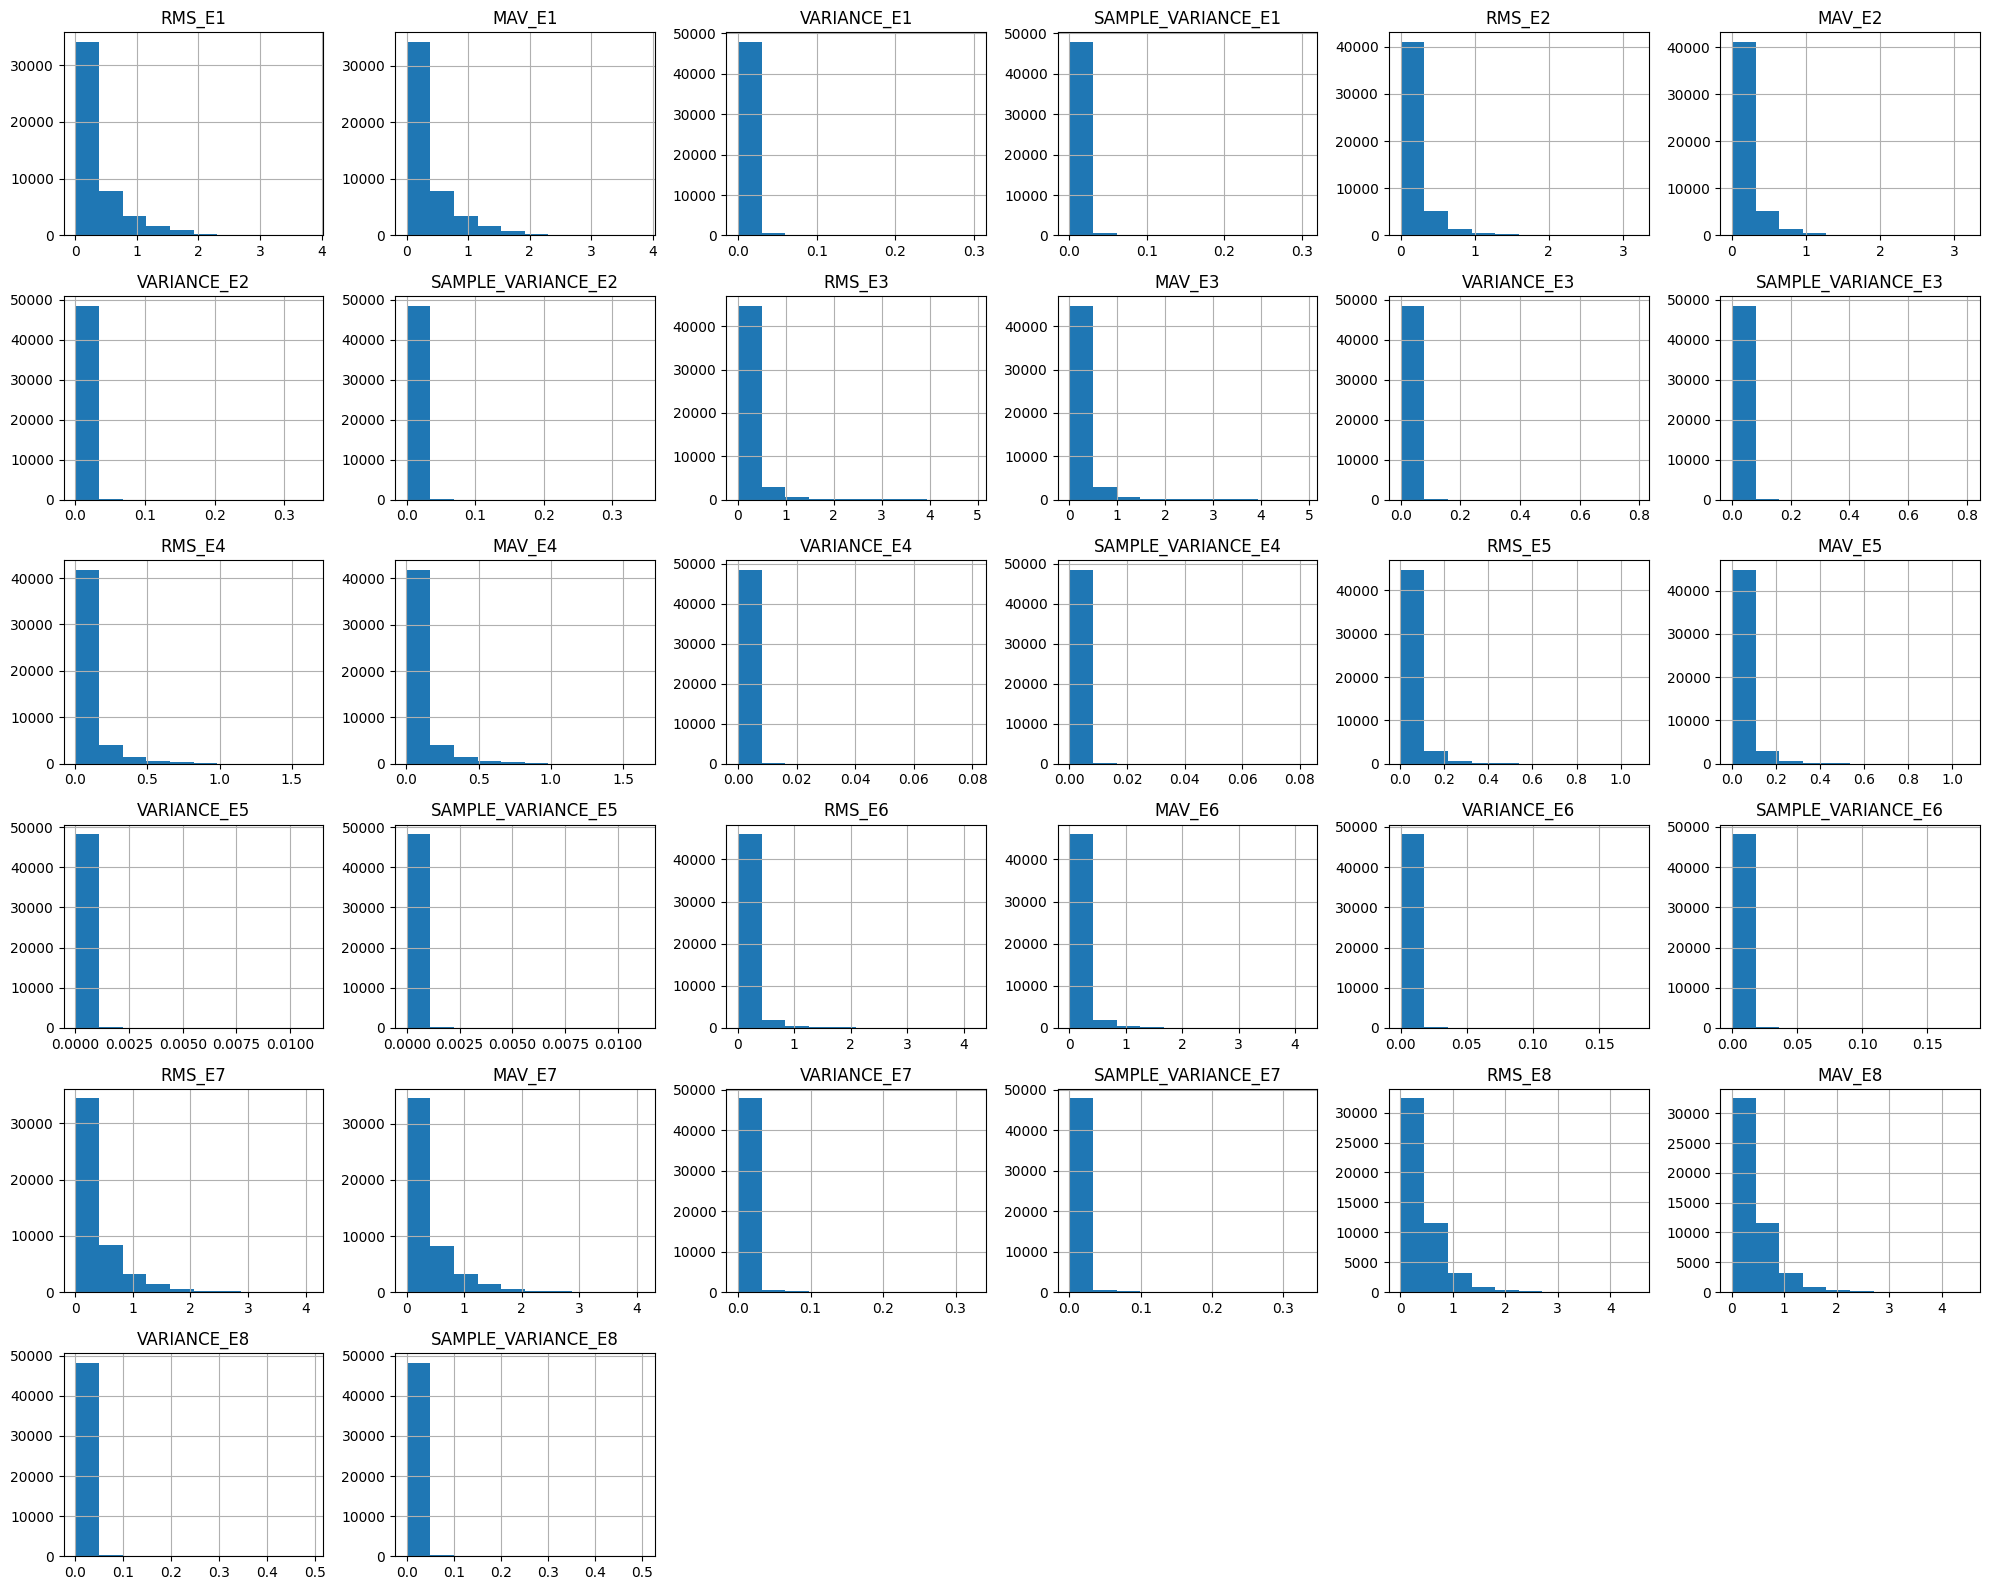

In [57]:
signals_features_df.hist(figsize=(20, 16))
plt.tight_layout()
plt.show()

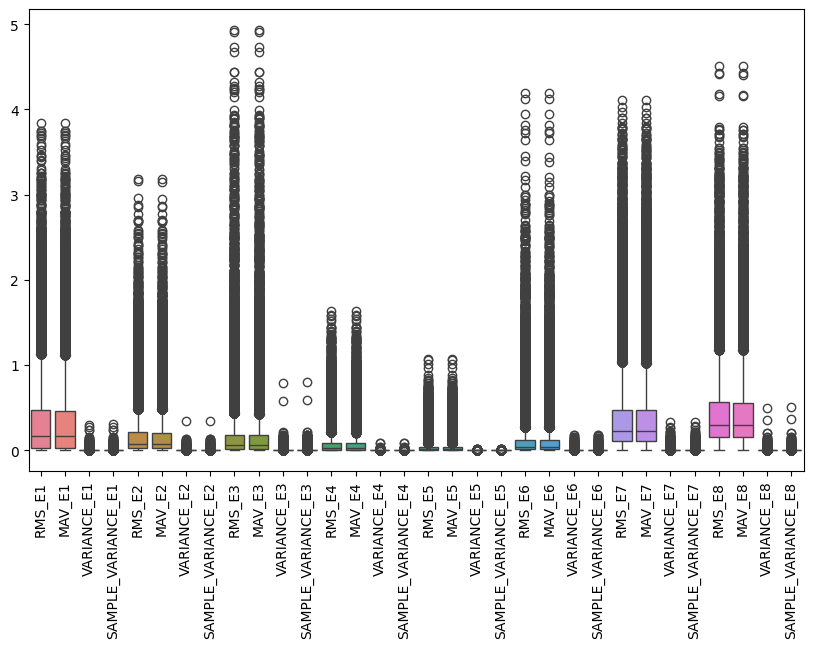

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=signals_features_df)
plt.xticks(rotation=90)  # Rotar etiquetas del eje x para mejor legibilidad
plt.show()

In [59]:

# Calcular z-score para todas las variables numéricas
z_scores = stats.zscore(signals_features_df.select_dtypes(include='number'))

# Convertir a DataFrame para facilitar el análisis
z_scores_df = pd.DataFrame(z_scores, columns=signals_features_df.select_dtypes(include='number').columns)

# Encontrar filas con algún valor de z-score por encima de un umbral
outliers = z_scores_df[(z_scores_df > 3).any(axis=1)]
print("Filas con valores atípicos (Z-Score > 3):")
print(outliers)

Filas con valores atípicos (Z-Score > 3):
         RMS_E1    MAV_E1  VARIANCE_E1  SAMPLE_VARIANCE_E1    RMS_E2  \
0     -0.307487 -0.303406    -0.334083           -0.334083  0.151747   
394   -0.241862 -0.242993    -0.184724           -0.184724  1.784051   
395   -0.077197 -0.081580    -0.003348           -0.003348  2.780183   
396    0.135023  0.130468     0.134153            0.134153  3.757724   
397    0.361163  0.359406     0.120480            0.120480  4.507448   
...         ...       ...          ...                 ...       ...   
49659 -0.752649 -0.749592    -0.336512           -0.336512 -0.003044   
49661 -0.752511 -0.749454    -0.336512           -0.336512  0.430686   
49662 -0.752650 -0.749593    -0.336512           -0.336512  0.579247   
49663 -0.752783 -0.749725    -0.336512           -0.336512  0.634282   
49664 -0.752733 -0.749677    -0.336512           -0.336512  0.579635   

         MAV_E2  VARIANCE_E2  SAMPLE_VARIANCE_E2    RMS_E3    MAV_E3  ...  \
0      0.137401 

 Como se observa anteriormente, se puede ver que existen muchos valores atípicos. Sin embargo, no vamos a omitirlos para ver como resulta el entrenamiento haciendo uso de los mismos. Procedemos a aplicar algoritmos de clasificación que no necesitan normalización


### 1. Random Forest

In [60]:
#Get data divided in train and test
features = signals_features_df.drop('label', axis=1) 
labels = signals_features_df['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

#Build the classifier
rf_classifier = RandomForestClassifier(n_estimators=300, random_state=32, criterion='gini')

#Train the classifier
rf_classifier.fit(X_train, y_train)

#Get prediction
y_pred = rf_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

Accuracy: 0.8816805684275564
Classification Report:
                precision    recall  f1-score   support

          Base       0.86      0.98      0.91      5614
       Lateral       0.91      0.69      0.78       752
   Medium Wrap       0.92      0.82      0.87       690
  Power Sphere       0.91      0.84      0.87       656
          Ring       0.92      0.83      0.87       669
        Tripod       0.94      0.71      0.81       687
Writing Tripod       0.94      0.64      0.76       643

      accuracy                           0.88      9711
     macro avg       0.91      0.79      0.84      9711
  weighted avg       0.89      0.88      0.88      9711

Confusion Matrix:
[[5474   38   29   24   25   12   12]
 [ 227  520    0    1    0    3    1]
 [ 103    1  567   13    3    1    2]
 [  81    5   11  551    2    4    2]
 [  97    2    1    5  556    3    5]
 [ 157    2   10   12   16  485    5]
 [ 218    6    0    0    3    7  409]]


In [61]:
#Get data divided in train and test
features = df_balanced.drop('label', axis=1) 
labels = df_balanced['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

#Build the classifier
rf_classifier = RandomForestClassifier(n_estimators=120, random_state=32, criterion='gini')

#Train the classifier
rf_classifier.fit(X_train, y_train)

#Get prediction
y_pred = rf_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

Accuracy: 0.8763440860215054
Classification Report:
                precision    recall  f1-score   support

          Base       0.78      0.74      0.76       660
       Lateral       0.87      0.90      0.88       631
   Medium Wrap       0.90      0.92      0.91       626
  Power Sphere       0.93      0.89      0.91       626
          Ring       0.89      0.94      0.92       652
        Tripod       0.89      0.87      0.88       620
Writing Tripod       0.88      0.86      0.87       649

      accuracy                           0.88      4464
     macro avg       0.88      0.88      0.88      4464
  weighted avg       0.88      0.88      0.88      4464

Confusion Matrix:
[[491  49  25  13  25  20  37]
 [ 41 571   2   3   1   4   9]
 [  9   1 575  19   7   9   6]
 [  6   5  22 560  14  12   7]
 [ 14   5   3   2 616  10   2]
 [ 19   8  12   5  22 539  15]
 [ 47  21   3   3   4  11 560]]


In [62]:
#Get data divided in train and test
features = df_filtered.drop('label', axis=1) 
labels = df_filtered['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

#Build the classifier
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=32, criterion='gini')

#Train the classifier
rf_classifier.fit(X_train, y_train)

#Get prediction
y_pred = rf_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

Accuracy: 0.9175946547884187
Classification Report:
                precision    recall  f1-score   support

       Lateral       0.91      0.97      0.94       766
   Medium Wrap       0.90      0.92      0.91       685
  Power Sphere       0.93      0.88      0.90       669
          Ring       0.93      0.95      0.94       675
        Tripod       0.94      0.84      0.89       642
Writing Tripod       0.90      0.93      0.92       604

      accuracy                           0.92      4041
     macro avg       0.92      0.92      0.92      4041
  weighted avg       0.92      0.92      0.92      4041

Confusion Matrix:
[[744   2   2   4   2  12]
 [ 11 630  23   8   7   6]
 [ 13  39 590  13   7   7]
 [  5   9   2 643  10   6]
 [ 22  15  18  17 541  29]
 [ 22   4   2   5  11 560]]


### 2. Naive Bayes

In [63]:
#Get data divided in train and test
features = signals_features_df.drop('label', axis=1) 
labels = signals_features_df['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

#Build the classifier
rf_classifier = GaussianNB()

#Train the classifier
rf_classifier.fit(X_train, y_train)

#Get prediction
y_pred = rf_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

Accuracy: 0.1828853877046648
Classification Report:
                precision    recall  f1-score   support

          Base       0.80      0.06      0.11      5614
       Lateral       0.10      0.86      0.18       752
   Medium Wrap       0.36      0.22      0.27       690
  Power Sphere       0.53      0.33      0.40       656
          Ring       0.39      0.27      0.32       669
        Tripod       0.20      0.29      0.24       687
Writing Tripod       0.09      0.11      0.10       643

      accuracy                           0.18      9711
     macro avg       0.35      0.30      0.23      9711
  weighted avg       0.58      0.18      0.17      9711

Confusion Matrix:
[[ 323 4494  100   65   80  212  340]
 [   6  644    8    6    4   35   49]
 [  25  161  149   58   85  147   65]
 [  16   84   92  214   46  188   16]
 [  20  101   45   41  179  176  107]
 [   4  262   17   22   44  199  139]
 [  12  497    3    1   18   44   68]]


In [64]:
#Get data divided in train and test
features = df_balanced.drop('label', axis=1) 
labels = df_balanced['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

#Build the classifier
rf_classifier = GaussianNB()

#Train the classifier
rf_classifier.fit(X_train, y_train)

#Get prediction
y_pred = rf_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

Accuracy: 0.29368279569892475
Classification Report:
                precision    recall  f1-score   support

          Base       0.34      0.05      0.09       660
       Lateral       0.25      0.87      0.39       631
   Medium Wrap       0.45      0.19      0.27       626
  Power Sphere       0.63      0.31      0.42       626
          Ring       0.47      0.26      0.34       652
        Tripod       0.21      0.27      0.23       620
Writing Tripod       0.16      0.11      0.13       649

      accuracy                           0.29      4464
     macro avg       0.36      0.30      0.27      4464
  weighted avg       0.36      0.29      0.27      4464

Confusion Matrix:
[[ 36 515   7   8   4  33  57]
 [ 12 550   0   5   4  32  28]
 [ 26 134 119  54  88 150  55]
 [ 11  94  69 193  44 199  16]
 [  7  99  47  27 172 172 128]
 [  3 274  18  17  33 167 108]
 [ 11 491   2   0  21  50  74]]


In [65]:
#Get data divided in train and test
features = df_filtered.drop('label', axis=1) 
labels = df_filtered['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

#Build the classifier
rf_classifier = GaussianNB()

#Train the classifier
rf_classifier.fit(X_train, y_train)

#Get prediction
y_pred = rf_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

Accuracy: 0.3674832962138085
Classification Report:
                precision    recall  f1-score   support

       Lateral       0.38      0.87      0.53       766
   Medium Wrap       0.49      0.23      0.31       685
  Power Sphere       0.64      0.33      0.44       669
          Ring       0.47      0.28      0.35       675
        Tripod       0.23      0.28      0.25       642
Writing Tripod       0.16      0.11      0.13       604

      accuracy                           0.37      4041
     macro avg       0.39      0.35      0.34      4041
  weighted avg       0.40      0.37      0.34      4041

Confusion Matrix:
[[669   4   6  10  28  49]
 [148 157  61  94 162  63]
 [ 96 101 222  48 184  18]
 [103  46  28 192 185 121]
 [279   8  30  41 178 106]
 [458   3   0  23  53  67]]


## Aplicar normalización

In [66]:
features = signals_features_df.drop('label', axis=1) 
labels = signals_features_df['label'] 

min_max_scaler = MinMaxScaler() # We can use StandardScaler, which provides values with a mean of 0 and a standard deviation of 1. Meanwhile, MinMaxScaler scales the data to a range of 0 to 1.
X_normalized = min_max_scaler.fit_transform(X)

X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

df_normalized = pd.concat([X_normalized_df, labels.reset_index(drop=True)], axis=1)

print(df_normalized.describe())


             RMS_E1        MAV_E1   VARIANCE_E1  SAMPLE_VARIANCE_E1  \
count  48554.000000  48554.000000  48554.000000        48554.000000   
mean       0.086906      0.086359      0.008086            0.008086   
std        0.114639      0.114355      0.024028            0.024028   
min        0.000000      0.000000      0.000000            0.000000   
25%        0.006851      0.006627      0.000019            0.000019   
50%        0.042649      0.042120      0.000582            0.000582   
75%        0.121402      0.120303      0.004766            0.004766   
max        1.000000      1.000000      1.000000            1.000000   

             RMS_E2        MAV_E2   VARIANCE_E2  SAMPLE_VARIANCE_E2  \
count  48554.000000  48554.000000  48554.000000        48554.000000   
mean       0.051652      0.051226      0.002663            0.002663   
std        0.075035      0.074769      0.011534            0.011534   
min        0.000000      0.000000      0.000000            0.000000   
25%  

In [67]:
features = df_balanced.drop('label', axis=1) 
labels = df_balanced['label'] 

min_max_scaler = MinMaxScaler() # We can use StandardScaler, which provides values with a mean of 0 and a standard deviation of 1. Meanwhile, MinMaxScaler scales the data to a range of 0 to 1.
X_normalized = min_max_scaler.fit_transform(X)

X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

df_normalized_balanced = pd.concat([X_normalized_df, labels.reset_index(drop=True)], axis=1)

print(df_normalized_balanced.describe())


             RMS_E1        MAV_E1   VARIANCE_E1  SAMPLE_VARIANCE_E1  \
count  48554.000000  48554.000000  48554.000000        48554.000000   
mean       0.086906      0.086359      0.008086            0.008086   
std        0.114639      0.114355      0.024028            0.024028   
min        0.000000      0.000000      0.000000            0.000000   
25%        0.006851      0.006627      0.000019            0.000019   
50%        0.042649      0.042120      0.000582            0.000582   
75%        0.121402      0.120303      0.004766            0.004766   
max        1.000000      1.000000      1.000000            1.000000   

             RMS_E2        MAV_E2   VARIANCE_E2  SAMPLE_VARIANCE_E2  \
count  48554.000000  48554.000000  48554.000000        48554.000000   
mean       0.051652      0.051226      0.002663            0.002663   
std        0.075035      0.074769      0.011534            0.011534   
min        0.000000      0.000000      0.000000            0.000000   
25%  

### SVM

In [68]:
#Get data divided in train and test
features = df_normalized.drop('label', axis=1) 
labels = df_normalized['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale') ##modify hyperparameters

svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

Accuracy: 0.7564617444135516
Classification Report:
                precision    recall  f1-score   support

          Base       0.74      0.97      0.84      5614
       Lateral       0.75      0.22      0.34       752
   Medium Wrap       0.80      0.63      0.71       690
  Power Sphere       0.86      0.68      0.76       656
          Ring       0.79      0.69      0.74       669
        Tripod       0.74      0.39      0.52       687
Writing Tripod       0.74      0.15      0.25       643

      accuracy                           0.76      9711
     macro avg       0.78      0.53      0.59      9711
  weighted avg       0.76      0.76      0.72      9711

Confusion Matrix:
[[5472   21   38   24   37   18    4]
 [ 559  166    1    0    5    7   14]
 [ 190    1  437   17   17   23    5]
 [ 129    9   49  444    9   14    2]
 [ 167    4    4   11  460   22    1]
 [ 319   10   17   18   44  271    8]
 [ 517    9    1    3    8    9   96]]


### Redes Neuronales

Vamos a aplicar una red neuronal para diferenciar entre base y los demás ejercicios y después una red neuronal para poder clasificar cada movimiento

In [69]:
df_normalized_balanced['label'].value_counts()

label
Base              3188
Lateral           3188
Medium Wrap       3188
Power Sphere      3188
Ring              3188
Tripod            3188
Writing Tripod    3188
Name: count, dtype: int64

In [70]:
df_normalized['label'].value_counts()

label
Base              28351
Lateral            3729
Ring               3451
Medium Wrap        3373
Power Sphere       3257
Writing Tripod     3205
Tripod             3188
Name: count, dtype: int64

Vamos a aplicar base vs los demás para hacer la primer clasificación

In [71]:
df_base = df_normalized.copy()
condition = df_base['label'] != 'Base'
df_base.loc[condition, 'label'] ='not-base'

In [72]:
df_base['label'].value_counts()

label
Base        28351
not-base    20203
Name: count, dtype: int64

#### Primera red neuronal:
Clasificar en base y no base

In [73]:
label_encoder = LabelEncoder()
df_base['label_encoded'] = label_encoder.fit_transform(df_base['label'])

In [74]:
df_base.head()

,RMS_E1,MAV_E1,VARIANCE_E1,SAMPLE_VARIANCE_E1,RMS_E2,MAV_E2,VARIANCE_E2,SAMPLE_VARIANCE_E2,RMS_E3,MAV_E3,...,RMS_E7,MAV_E7,VARIANCE_E7,SAMPLE_VARIANCE_E7,RMS_E8,MAV_E8,VARIANCE_E8,SAMPLE_VARIANCE_E8,label,label_encoded
0,0.051656,0.051663,0.000058,0.000058,0.063038,0.061499,0.005862,0.005862,0.092903,0.090240,...,0.090397,0.088829,0.014825,0.014825,0.070679,0.069865,0.004954,0.004954,Base,0
1,0.050041,0.050035,0.000124,0.000124,0.048104,0.047916,0.000600,0.000600,0.069202,0.068887,...,0.071167,0.070876,0.002310,0.002310,0.058262,0.058116,0.000871,0.000871,Base,0
2,0.046892,0.046866,0.000211,0.000211,0.041674,0.041589,0.000257,0.000257,0.059364,0.059231,...,0.061239,0.061079,0.001156,0.001156,0.051041,0.050940,0.000573,0.000573,Base,0
3,0.042980,0.042928,0.000300,0.000300,0.037212,0.037163,0.000146,0.000146,0.052729,0.052659,...,0.054081,0.053990,0.000634,0.000634,0.044941,0.044854,0.000451,0.000451,Base,0
4,0.038507,0.038431,0.000360,0.000360,0.033752,0.033720,0.000095,0.000095,0.047716,0.047677,...,0.048716,0.048664,0.000371,0.000371,0.039432,0.039349,0.000383,0.000383,Base,0


In [75]:
features = df_base.drop(columns=['label_encoded', 'label'], axis=1) 
labels = df_base['label_encoded'] 
labels = to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

c:\Users\CarlosMunoz\Desktop\protesis_avanzadas\IA-PA-UNIR\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7963 - loss: 0.5936 - val_accuracy: 0.8143 - val_loss: 0.4382
Epoch 2/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8168 - loss: 0.4342 - val_accuracy: 0.8194 - val_loss: 0.4279
Epoch 3/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8172 - loss: 0.4267 - val_accuracy: 0.8235 - val_loss: 0.4196
Epoch 4/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8237 - loss: 0.4156 - val_accuracy: 0.8210 - val_loss: 0.4171
Epoch 5/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8264 - loss: 0.4115 - val_accuracy: 0.8242 - val_loss: 0.4078
Epoch 6/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8234 - loss: 0.4122 - val_accuracy: 0.8270 - val_loss: 0.4068
Epoch 7/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8326 - loss: 0.3938 - val_accuracy: 0.8320 - val_loss: 0.3999
Epoch 8/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8333 - loss: 0

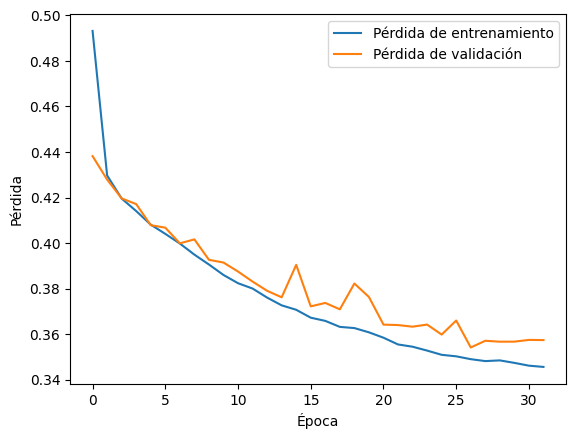

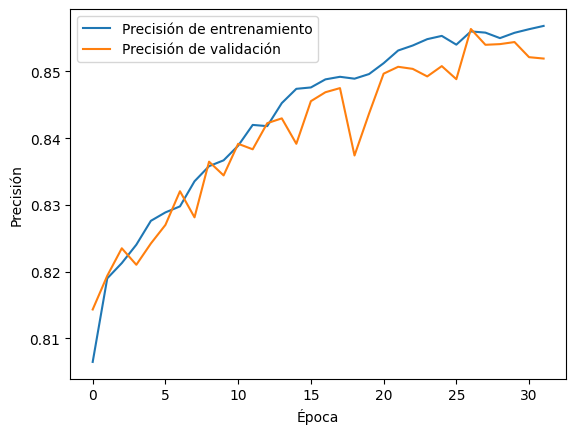

In [76]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(8, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

import matplotlib.pyplot as plt

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Epoch 1/100


c:\Users\CarlosMunoz\Desktop\protesis_avanzadas\IA-PA-UNIR\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1943/1943 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7825 - loss: 0.6277 - val_accuracy: 0.8068 - val_loss: 0.4539
Epoch 2/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8186 - loss: 0.4394 - val_accuracy: 0.8152 - val_loss: 0.4352
Epoch 3/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8196 - loss: 0.4306 - val_accuracy: 0.8148 - val_loss: 0.4315
Epoch 4/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8178 - loss: 0.4280 - val_accuracy: 0.8198 - val_loss: 0.4240
Epoch 5/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8215 - loss: 0.4216 - val_accuracy: 0.8186 - val_loss: 0.4223
Epoch 6/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8250 - loss: 0.4167 - val_accuracy: 0.8219 - val_loss: 0.4181
Epoch 7/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8247 - loss: 0.4162 - val_accuracy: 0.8232 - val_loss: 0.4145
Epoch 8/100
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8226 - loss: 0.4187 - val_

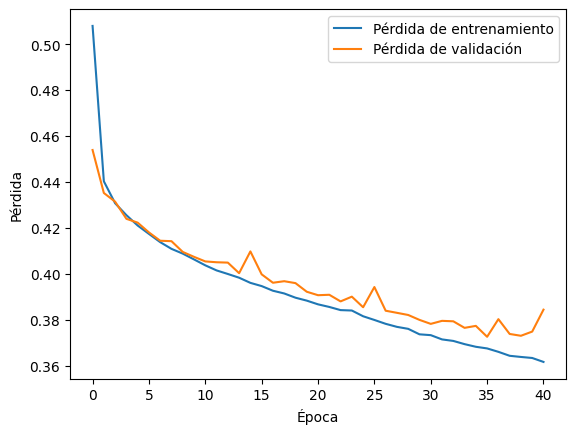

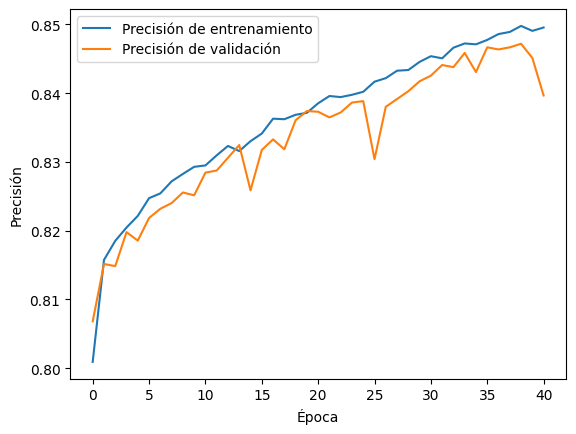

In [77]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

import matplotlib.pyplot as plt

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

### Segunda Red Neuronal
Vamos ahora a clasificar los modelos sin base 

In [78]:
df_normalized.head()

,RMS_E1,MAV_E1,VARIANCE_E1,SAMPLE_VARIANCE_E1,RMS_E2,MAV_E2,VARIANCE_E2,SAMPLE_VARIANCE_E2,RMS_E3,MAV_E3,...,SAMPLE_VARIANCE_E6,RMS_E7,MAV_E7,VARIANCE_E7,SAMPLE_VARIANCE_E7,RMS_E8,MAV_E8,VARIANCE_E8,SAMPLE_VARIANCE_E8,label
0,0.051656,0.051663,0.000058,0.000058,0.063038,0.061499,0.005862,0.005862,0.092903,0.090240,...,0.000147,0.090397,0.088829,0.014825,0.014825,0.070679,0.069865,0.004954,0.004954,Base
1,0.050041,0.050035,0.000124,0.000124,0.048104,0.047916,0.000600,0.000600,0.069202,0.068887,...,0.000041,0.071167,0.070876,0.002310,0.002310,0.058262,0.058116,0.000871,0.000871,Base
2,0.046892,0.046866,0.000211,0.000211,0.041674,0.041589,0.000257,0.000257,0.059364,0.059231,...,0.000024,0.061239,0.061079,0.001156,0.001156,0.051041,0.050940,0.000573,0.000573,Base
3,0.042980,0.042928,0.000300,0.000300,0.037212,0.037163,0.000146,0.000146,0.052729,0.052659,...,0.000016,0.054081,0.053990,0.000634,0.000634,0.044941,0.044854,0.000451,0.000451,Base
4,0.038507,0.038431,0.000360,0.000360,0.033752,0.033720,0.000095,0.000095,0.047716,0.047677,...,0.000011,0.048716,0.048664,0.000371,0.000371,0.039432,0.039349,0.000383,0.000383,Base


In [79]:
df_normalized['label'].value_counts()

label
Base              28351
Lateral            3729
Ring               3451
Medium Wrap        3373
Power Sphere       3257
Writing Tripod     3205
Tripod             3188
Name: count, dtype: int64

In [80]:
index_to_delete = df_normalized[df_normalized['label'] == 'Base'].index

df_normalized.drop(index_to_delete, inplace=True)

In [81]:
df_normalized['label'].value_counts()

label
Lateral           3729
Ring              3451
Medium Wrap       3373
Power Sphere      3257
Writing Tripod    3205
Tripod            3188
Name: count, dtype: int64

In [82]:
label_encoder = LabelEncoder()
df_normalized['label_encoded'] = label_encoder.fit_transform(df_normalized['label'])

In [83]:
df_normalized['label_encoded'].value_counts()

label_encoded
0    3729
3    3451
1    3373
2    3257
5    3205
4    3188
Name: count, dtype: int64

In [84]:
df_normalized['label'].value_counts()

label
Lateral           3729
Ring              3451
Medium Wrap       3373
Power Sphere      3257
Writing Tripod    3205
Tripod            3188
Name: count, dtype: int64

In [85]:
df_normalized.head()

,RMS_E1,MAV_E1,VARIANCE_E1,SAMPLE_VARIANCE_E1,RMS_E2,MAV_E2,VARIANCE_E2,SAMPLE_VARIANCE_E2,RMS_E3,MAV_E3,...,RMS_E7,MAV_E7,VARIANCE_E7,SAMPLE_VARIANCE_E7,RMS_E8,MAV_E8,VARIANCE_E8,SAMPLE_VARIANCE_E8,label,label_encoded
75,0.057446,0.057055,0.002319,0.002319,0.177269,0.176964,0.003791,0.003791,0.103203,0.102973,...,0.212623,0.212526,0.002722,0.002722,0.099438,0.099247,0.001833,0.001833,Medium Wrap,1
76,0.067333,0.067180,0.001148,0.001148,0.187013,0.187043,0.000272,0.000272,0.110325,0.110337,...,0.216829,0.216839,0.000359,0.000359,0.106604,0.106611,0.000215,0.000215,Medium Wrap,1
77,0.073159,0.073146,0.000239,0.000239,0.178404,0.178103,0.003769,0.003769,0.106940,0.106832,...,0.209454,0.209373,0.002310,0.002310,0.105862,0.105854,0.000358,0.000358,Medium Wrap,1
78,0.074472,0.074488,0.000031,0.000031,0.152073,0.150691,0.012961,0.012961,0.093877,0.093345,...,0.197503,0.197402,0.002583,0.002583,0.098303,0.098145,0.001549,0.001549,Medium Wrap,1
79,0.072029,0.072012,0.000264,0.000264,0.112324,0.109001,0.022322,0.022322,0.074583,0.073564,...,0.185615,0.185519,0.002316,0.002316,0.086504,0.086203,0.002392,0.002392,Medium Wrap,1


In [86]:
features = df_normalized.drop(columns=['label_encoded', 'label'], axis=1) 
labels = df_normalized['label_encoded'] 
labels = to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

Epoch 1/150


c:\Users\CarlosMunoz\Desktop\protesis_avanzadas\IA-PA-UNIR\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1617/1617 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4492 - loss: 1.3710 - val_accuracy: 0.5900 - val_loss: 1.0441 - learning_rate: 0.0020
Epoch 2/150
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5928 - loss: 1.0205 - val_accuracy: 0.6706 - val_loss: 0.8720 - learning_rate: 0.0030
Epoch 3/150
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6498 - loss: 0.8760 - val_accuracy: 0.7167 - val_loss: 0.7279 - learning_rate: 0.0040
Epoch 4/150
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6927 - loss: 0.7672 - val_accuracy: 0.7340 - val_loss: 0.6986 - learning_rate: 0.0050
Epoch 5/150
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7239 - loss: 0.7076 - val_accuracy: 0.7261 - val_loss: 0.7096 - learning_rate: 0.0060
Epoch 6/150
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7371 - loss: 0.6722 - val_accuracy: 0.7585 - val_loss: 0.6171 - learning_rate: 0.0070
Epoch 7/150
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7518 - loss: 

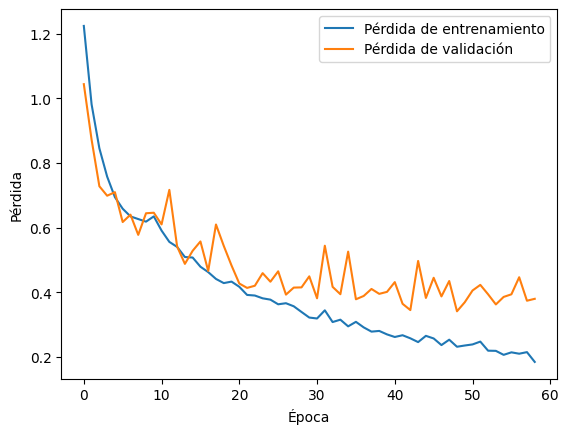

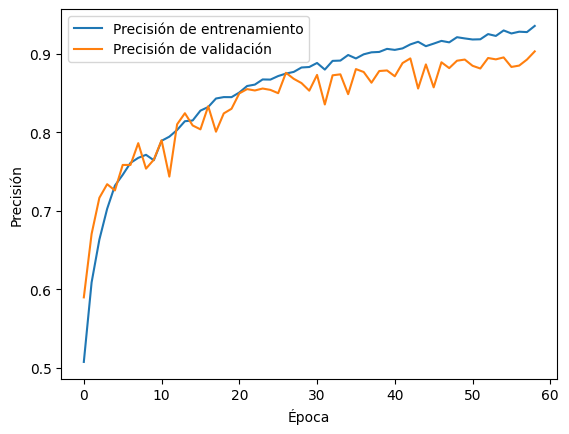

In [87]:
model = Sequential()
model.add(Dense(80, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
lr_scheduler = LearningRateScheduler(src.warmup_scheduler) #Aumenta la taza de aprendizaje al inicio y luego la disminuye 

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]
)

import matplotlib.pyplot as plt

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Epoch 1/150


c:\Users\CarlosMunoz\Desktop\protesis_avanzadas\IA-PA-UNIR\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


809/809 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4195 - loss: 1.4487 - val_accuracy: 0.5501 - val_loss: 1.1481
Epoch 2/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5459 - loss: 1.1370 - val_accuracy: 0.5882 - val_loss: 1.0336
Epoch 3/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6007 - loss: 1.0090 - val_accuracy: 0.6357 - val_loss: 0.9199
Epoch 4/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6463 - loss: 0.8989 - val_accuracy: 0.6855 - val_loss: 0.8265
Epoch 5/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6850 - loss: 0.8183 - val_accuracy: 0.6983 - val_loss: 0.7845
Epoch 6/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7155 - loss: 0.7497 - val_accuracy: 0.7268 - val_loss: 0.7365
Epoch 7/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7301 - loss: 0.7102 - val_accuracy: 0.7503 - val_loss: 0.6629
Epoch 8/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7591 - loss: 0.6360 - val_accuracy: 0.7617

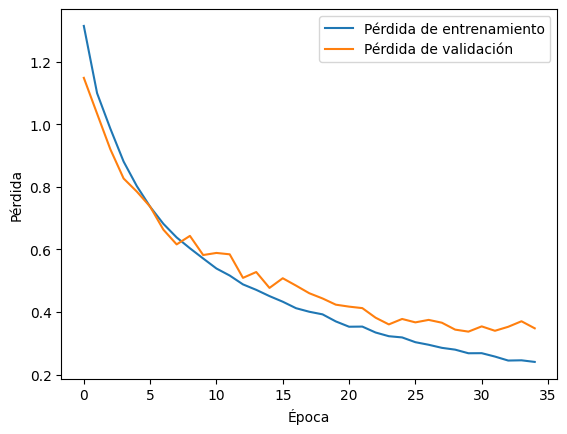

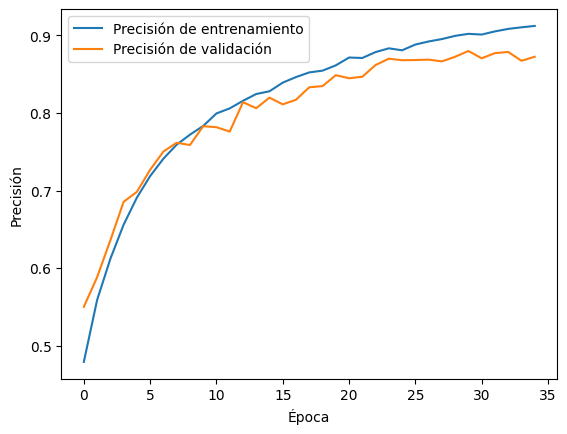

In [88]:
model = Sequential()
model.add(Dense(150, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

import matplotlib.pyplot as plt

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()